In [ ]:
# ==========================================
# PASO 1-2-3: Instalación de Dependencias
# ==========================================
!pip install -q transformers diffusers gradio torch accelerate Pillow google-generativeai xformers
!pip install -q colorthief scikit-learn
!pip install -q rouge-score nltk pandas matplotlib seaborn
!pip install -q textstat

import torch
import gradio as gr
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
from PIL import Image, ImageDraw, ImageFont
import google.generativeai as genai
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from colorthief import ColorThief
from io import BytesIO
import numpy as np
import pandas as pd
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

print("✓ Imports completados")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.4 MB/s eta 0:00:00
✓ Imports completados


In [ ]:
# ==========================================
# PASO 4: Configurar Gemini API
# ==========================================
# try:
#     from google.colab import userdata
#     GOOGLE_API_KEY = userdata.get('deeplearning')
#     print("✓ API Key obtenida de Secrets")
# except:
#     # MÉTODO 2: Configuración directa
#     # ⚠️ REEMPLAZA con tu API key:
#     GOOGLE_API_KEY = 'TU_API_KEY_AQUI'
#     print("⚠️ Usando API key directa")

# # Configurar Gemini
# if GOOGLE_API_KEY and GOOGLE_API_KEY != 'TU_API_KEY_AQUI':
#     genai.configure(api_key=GOOGLE_API_KEY)
#     print("✓ Gemini configurado correctamente")
# else:
#     print("❌ Configura tu API key")
#     GOOGLE_API_KEY = None


✓ API Key obtenida de Secrets
✓ Gemini configurado correctamente


In [ ]:
# ==========================================
# PASO 4: Utilizar para Hugging Face - Configurar Gemini API
# ==========================================
# Intentar obtener la API key de las variables de entorno del sistema
# El nombre de la variable debe coincidir con el que configuraste en Hugging Face (por ej., GOOGLE_API_KEY)
GOOGLE_API_KEY = os.getenv('deeplearning')

# Configurar Gemini
if GOOGLE_API_KEY:
    genai.configure(api_key=GOOGLE_API_KEY)
    print("✓ Gemini configurado correctamente usando variables de entorno")
else:
    print("❌ No se encontró la API key en las variables de entorno. Asegúrate de configurarla en los secretos del repositorio de Hugging Face.")
    GOOGLE_API_KEY = None


In [ ]:
# ==========================================
# PASO 5: Cargar Stable Diffusion
# ==========================================
model_id = "runwayml/stable-diffusion-v1-5"
print(f"Cargando {model_id}...")

sd_pipeline = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    safety_checker=None,
    requires_safety_checker=False
)

sd_pipeline.scheduler = DPMSolverMultistepScheduler.from_config(
    sd_pipeline.scheduler.config
)
sd_pipeline.enable_attention_slicing()
sd_pipeline.enable_xformers_memory_efficient_attention()
sd_pipeline = sd_pipeline.to("cuda")

print("✓ Stable Diffusion cargado")

Cargando runwayml/stable-diffusion-v1-5...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


ValueError: torch.cuda.is_available() should be True but is False. xformers' memory efficient attention is only available for GPU 

In [ ]:
# ==========================================
# PASO 6: Dataset de Ejemplos Educativos
# ==========================================

# Dataset de ejemplos para experimentación
dataset_ejemplos = pd.DataFrame({
    'tema': [
        'matemáticas', 'matemáticas', 'matemáticas',
        'física', 'física', 'física',
        'química', 'química', 'química',
        'biología', 'biología', 'biología',
        'historia', 'historia', 'historia',
        'geografía', 'geografía', 'geografía'
    ],
    'concepto': [
        'ecuaciones cuadráticas', 'teorema de Pitágoras', 'derivadas',
        'gravedad', 'energía cinética', 'leyes de Newton',
        'enlaces químicos', 'tabla periódica', 'reacciones químicas',
        'fotosíntesis', 'mitosis', 'ADN',
        'revolución francesa', 'segunda guerra mundial', 'imperio romano',
        'placas tectónicas', 'clima', 'continentes'
    ],
    'nivel': [
        'secundaria', 'secundaria', 'universitario',
        'secundaria', 'secundaria', 'universitario',
        'secundaria', 'secundaria', 'universitario',
        'secundaria', 'secundaria', 'universitario',
        'secundaria', 'universitario', 'secundaria',
        'secundaria', 'secundaria', 'primaria'
    ]
})

print(f"✓ Dataset creado: {len(dataset_ejemplos)} ejemplos")
print(f"  Temas: {dataset_ejemplos['tema'].nunique()}")
print(f"  Niveles: {dataset_ejemplos['nivel'].nunique()}")

✓ Dataset creado: 18 ejemplos
  Temas: 6
  Niveles: 3


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/tmp/ipython-input-3499932584.py:50: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3499932584.py:51: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig('eda_dataset.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3499932584.py:51: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.savefig('eda_dataset.png', dpi=150, bbox_inches='tight')
/tmp/ipython-input-3499932584.py:51: UserWarning: Glyph 128293 (\N{FIRE}) missing from font(s) DejaVu Sans.
  plt.savefig('eda_dataset.png', dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IP

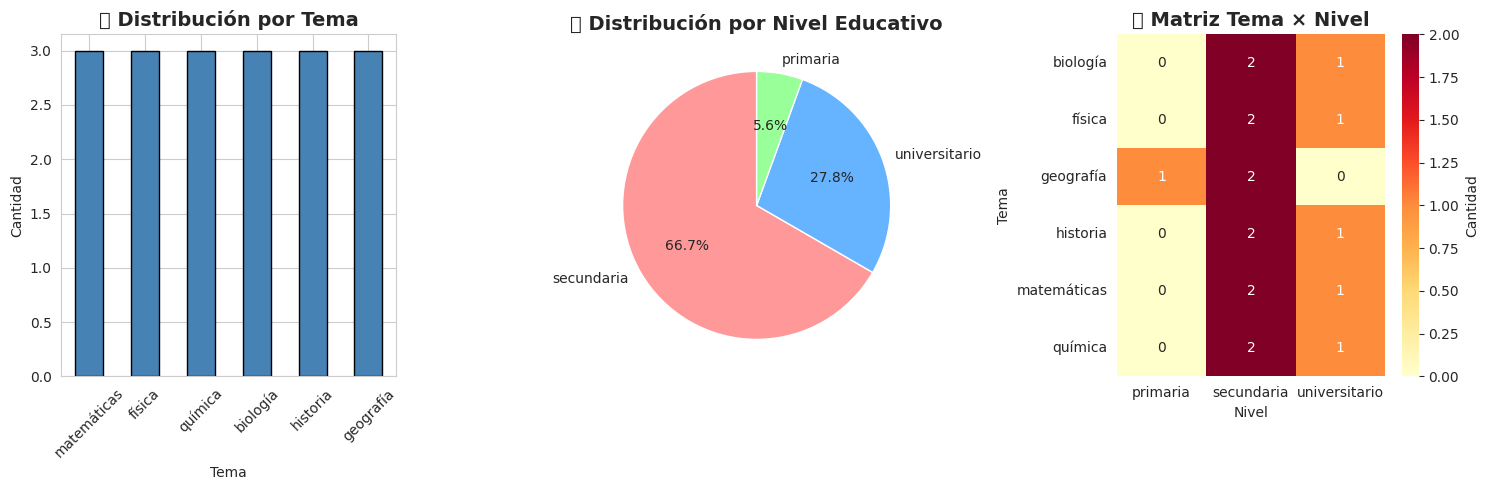

✓ EDA completado
  Gráfico guardado: eda_dataset.png


In [ ]:
# ==========================================
# PASO 7: Análisis Exploratorio de Datos (EDA)
# ==========================================

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 5)

# Crear visualizaciones
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Gráfico 1: Distribución por tema
dataset_ejemplos['tema'].value_counts().plot(
    kind='bar',
    ax=axes[0],
    color='steelblue',
    edgecolor='black'
)
axes[0].set_title('📊 Distribución por Tema', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Tema')
axes[0].set_ylabel('Cantidad')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Distribución por nivel
nivel_counts = dataset_ejemplos['nivel'].value_counts()
colors = ['#ff9999', '#66b3ff', '#99ff99']
axes[1].pie(
    nivel_counts.values,
    labels=nivel_counts.index,
    autopct='%1.1f%%',
    colors=colors,
    startangle=90
)
axes[1].set_title('📚 Distribución por Nivel Educativo', fontsize=14, fontweight='bold')

# Gráfico 3: Matriz tema x nivel
pivot_table = pd.crosstab(dataset_ejemplos['tema'], dataset_ejemplos['nivel'])
sns.heatmap(
    pivot_table,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    ax=axes[2],
    cbar_kws={'label': 'Cantidad'}
)
axes[2].set_title('🔥 Matriz Tema × Nivel', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Nivel')
axes[2].set_ylabel('Tema')

plt.tight_layout()
plt.savefig('eda_dataset.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ EDA completado")
print(f"  Gráfico guardado: eda_dataset.png")

In [ ]:
# ==========================================
# PASO 8: Configurar Fuentes
# ==========================================
DEJAVU_BOLD = "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf"
DEJAVU_REGULAR = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"

try:
    FONT_TITLE = ImageFont.truetype(DEJAVU_BOLD, 48)
    FONT_SUBTITLE = ImageFont.truetype(DEJAVU_BOLD, 32)
    FONT_BODY = ImageFont.truetype(DEJAVU_REGULAR, 24)
    FONT_SMALL = ImageFont.truetype(DEJAVU_REGULAR, 18)
    print("✓ Fuentes DejaVu cargadas")
except:
    FONT_TITLE = ImageFont.load_default()
    FONT_SUBTITLE = ImageFont.load_default()
    FONT_BODY = ImageFont.load_default()
    FONT_SMALL = ImageFont.load_default()
    print("⚠️ Usando fuentes por defecto")



⚠️ Usando fuentes por defecto


In [ ]:
# ==========================================
# PASO 9: Función Auxiliar wrap_text
# ==========================================

def wrap_text(text, font, max_width):
    """
    Divide el texto en múltiples líneas para que quepa en el ancho máximo
    """
    words = text.split()
    lines = []
    current_line = []

    for word in words:
        # Probar agregando la palabra a la línea actual
        test_line = ' '.join(current_line + [word])

        # Usar textbbox para medir el ancho (compatible con Pillow moderno)
        from PIL import ImageDraw, Image
        test_img = Image.new('RGB', (1, 1))
        test_draw = ImageDraw.Draw(test_img)
        bbox = test_draw.textbbox((0, 0), test_line, font=font)
        text_width = bbox[2] - bbox[0]

        if text_width <= max_width:
            current_line.append(word)
        else:
            if current_line:
                lines.append(' '.join(current_line))
                current_line = [word]
            else:
                # Palabra muy larga, agregarla de todos modos
                lines.append(word)

    # Agregar la última línea
    if current_line:
        lines.append(' '.join(current_line))

    return '\n'.join(lines)

print("✓ Función wrap_text definida")

✓ Función wrap_text definida


In [ ]:
# ==========================================
# CEPASO 10: Función de Extracción
# ==========================================
def extract_topic_and_concept(user_input):
    """Extrae tema y concepto de la pregunta"""
    user_input = user_input.lower()

    patterns = [
        r"(?:sobre|de)\s+(\w+)\s+(?:de|sobre)\s+(.+)",
        r"(\w+)\s+(?:de|sobre)\s+(.+)",
    ]

    for pattern in patterns:
        match = re.search(pattern, user_input)
        if match:
            return match.group(1).strip(), match.group(2).strip()

    return "educación", user_input

In [ ]:
# ==========================================
# PASO 11:  Prompts
# ==========================================
PROMPTS_POR_TEMA = {
    "matemáticas": "mathematical equations, formulas, graphs, geometric shapes, numbers, algebra, calculus symbols",
    "matematicas": "mathematical equations, formulas, graphs, geometric shapes, numbers, algebra, calculus symbols",
    "física": "physics diagrams, forces, energy, waves, atoms, particles, scientific illustrations",
    "fisica": "physics diagrams, forces, energy, waves, atoms, particles, scientific illustrations",
    "química": "chemical structures, molecules, periodic table elements, atoms, bonds, reactions",
    "quimica": "chemical structures, molecules, periodic table elements, atoms, bonds, reactions",
    "biología": "biological cells, DNA, organisms, plants, animals, microscopic view, nature",
    "biologia": "biological cells, DNA, organisms, plants, animals, microscopic view, nature",
    "historia": "historical timeline, ancient artifacts, maps, documents, vintage style",
    "geografía": "maps, terrain, continents, rivers, mountains, earth, globe",
    "geografia": "maps, terrain, continents, rivers, mountains, earth, globe",
    "informática": "code, algorithms, flowcharts, binary, circuits, technology",
    "informatica": "code, algorithms, flowcharts, binary, circuits, technology",
    "literatura": "books, writing, manuscripts, poetry, letters, classic literature",
    "arte": "paintings, sculptures, artistic elements, brushstrokes, canvas",
    "música": "musical notes, instruments, sheet music, sound waves, melody",
    "musica": "musical notes, instruments, sheet music, sound waves, melody",
}

ESTILOS_VISUALES = {
    "Minimalista": "minimalist, clean, simple, elegant, white background",
    "Artístico": "artistic, painterly, textured, expressive, colorful",
    "3D Moderno": "3d render, modern, sleek, professional, high quality",
    "Educativo Clásico": "educational, textbook style, clear, academic, professional"
}

In [ ]:
# ==========================================
# PASO 12: Colores
# ==========================================
def extraer_colores_dominantes(imagen_pil, n_colores=5):
    """Extrae los colores dominantes de una imagen"""
    try:
        # Convertir PIL Image a bytes
        img_byte_arr = BytesIO()
        imagen_pil.save(img_byte_arr, format='PNG')
        img_byte_arr.seek(0)

        # Extraer paleta de colores
        color_thief = ColorThief(img_byte_arr)
        paleta = color_thief.get_palette(color_count=n_colores, quality=1)

        # Ordenar por luminosidad (del más claro al más oscuro)
        paleta_ordenada = sorted(paleta, key=lambda rgb: sum(rgb), reverse=True)

        return paleta_ordenada
    except Exception as e:
        print(f"⚠️ Error extrayendo colores: {e}")
        # Paleta por defecto
        return [(255, 255, 255), (200, 200, 200), (100, 100, 100), (50, 50, 50), (0, 0, 0)]


def ajustar_luminosidad(color_rgb, factor=1.2):
    """Ajusta la luminosidad de un color"""
    r, g, b = color_rgb
    r = min(255, int(r * factor))
    g = min(255, int(g * factor))
    b = min(255, int(b * factor))
    return (r, g, b)


def obtener_color_contraste(color_fondo):
    """Obtiene un color de texto con buen contraste"""
    r, g, b = color_fondo
    luminosidad = (0.299 * r + 0.587 * g + 0.114 * b)

    # Si el fondo es claro, usar texto oscuro
    if luminosidad > 128:
        return (30, 30, 30)
    else:
        return (255, 255, 255)


def crear_paleta_adaptativa(imagen_pil):
    """Crea una paleta de colores adaptada a la imagen"""
    colores = extraer_colores_dominantes(imagen_pil, n_colores=5)

    # Seleccionar colores para diferentes elementos
    color_fondo = ajustar_luminosidad(colores[0], 1.3)  # Más claro
    color_acento = colores[2]  # Color medio
    color_texto = obtener_color_contraste(color_fondo)

    return {
        'color_fondo': color_fondo,
        'color_acento': color_acento,
        'color_texto': color_texto,
        'paleta_completa': colores
    }

In [ ]:

# ==========================================
# PASO 13: Generación con Gemini
# ==========================================
def generate_with_gemini(tema, concepto):
    """Genera contenido usando Gemini API"""
    if not GOOGLE_API_KEY:
        return None, None

    try:
        model = genai.GenerativeModel('gemini-2.5-flash')

        prompt = f"""Sobre "{concepto}" en {tema}, proporciona:

1. Definición clara (máximo 150 caracteres)
2. Exactamente 4 puntos clave específicos

Formato:
DEFINICIÓN: [definición]

PUNTOS CLAVE:
1. [punto 1]
2. [punto 2]
3. [punto 3]
4. [punto 4]"""

        response = model.generate_content(prompt)

        # Parsear respuesta
        text = response.text
        definicion = ""
        puntos = []

        for line in text.split('\n'):
            line = line.strip()
            if 'DEFINICIÓN:' in line or 'Definición:' in line:
                definicion = line.split(':', 1)[1].strip()
            elif line and any(line.startswith(f'{i}.') for i in range(1, 10)):
                punto = line.lstrip('0123456789.-•* ').strip()
                if len(punto) > 15:
                    puntos.append(punto)

        return definicion, puntos, text  # ← RETORNA TAMBIÉN EL TEXTO COMPLETO

    except Exception as e:
        print(f"⚠️ Error Gemini: {e}")
        return None, None, None


In [ ]:
# ==========================================
# PASO 14: Fondo Visual
# ==========================================
def generate_visual_background(tema, concepto, estilo):
    """Genera fondo visual específico del tema"""

    # Obtener prompt específico del tema
    tema_lower = tema.lower()
    prompt_tema = PROMPTS_POR_TEMA.get(tema_lower, "educational diagrams, visual elements")

    # Obtener estilo visual
    estilo_visual = ESTILOS_VISUALES.get(estilo, ESTILOS_VISUALES[estilo])

    # Construir prompt completo SIN iconos genéricos
    prompt = f"""Educational illustration about {concepto} in {tema},
    {prompt_tema},
    {estilo_visual},
    relevant visual elements, clear composition,
    NO TEXT, NO WORDS, NO LABELS, high quality, detailed"""

    negative_prompt = """text, words, letters, writing, labels, watermark,
    generic icons, clipart, low quality, blurry, messy, chaotic"""

    print(f"  🎨 Prompt: {prompt[:100]}...")

    image = sd_pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=35,  # Más pasos para mejor calidad
        guidance_scale=7.5,
        height=768,
        width=768
    ).images[0]

    # Extraer colores de la imagen generada
    print("  🎨 Extrayendo colores dominantes...")
    paleta_colores = crear_paleta_adaptativa(image)

    return image, paleta_colores

In [ ]:
# ==========================================
# PASO 15: Overlay
# ==========================================
def add_text_overlay(background, tema, concepto, definicion, puntos, paleta_colores):
    """Añade texto con colores extraídos de la imagen"""

    img = background.copy()
    draw = ImageDraw.Draw(img)
    width, height = img.size

    # Usar colores extraídos de la imagen
    COLOR_BG = paleta_colores['color_fondo'] + (230,)  # Semi-transparente
    COLOR_TEXT = paleta_colores['color_texto']
    COLOR_ACCENT = paleta_colores['color_acento']

    print(f"  🎨 Colores: Fondo={paleta_colores['color_fondo']}, Acento={COLOR_ACCENT}")

    y = 40
    margin = 30

    # 1. TÍTULO con gradiente visual
    title = concepto.upper()
    title_bbox = draw.textbbox((0, 0), title, font=FONT_TITLE)
    title_w = title_bbox[2] - title_bbox[0]
    title_h = title_bbox[3] - title_bbox[1]

    # Sombra suave
    draw.rectangle(
        [(margin-3, y-3), (width - margin+3, y + title_h + 23)],
        fill=(0, 0, 0, 80)
    )
    # Fondo del título con color de la imagen
    draw.rectangle(
        [(margin, y), (width - margin, y + title_h + 20)],
        fill=COLOR_ACCENT
    )
    # Texto
    texto_titulo_color = obtener_color_contraste(COLOR_ACCENT)
    draw.text(
        ((width - title_w) // 2, y + 10),
        title,
        font=FONT_TITLE,
        fill=texto_titulo_color
    )
    y += title_h + 60

    # 2. SUBTÍTULO con badge adaptativo
    subtitle = f"📚 {tema.title()}"
    subtitle_bbox = draw.textbbox((0, 0), subtitle, font=FONT_SUBTITLE)
    subtitle_w = subtitle_bbox[2] - subtitle_bbox[0]

    # Badge con color complementario
    color_badge = ajustar_luminosidad(paleta_colores['paleta_completa'][1], 1.1)
    draw.rounded_rectangle(
        [(margin, y), (margin + subtitle_w + 20, y + 40)],
        radius=10,
        fill=color_badge + (200,)
    )
    draw.text(
        (margin + 10, y + 5),
        subtitle,
        font=FONT_SUBTITLE,
        fill=obtener_color_contraste(color_badge)
    )
    y += 60

    # 3. DEFINICIÓN con borde del color de la imagen
    if definicion:
        # Borde con color de acento
        draw.rectangle(
            [(margin-2, y-2), (width - margin+2, y + 82)],
            outline=COLOR_ACCENT,
            width=3
        )
        # Fondo adaptativo
        draw.rectangle(
            [(margin, y), (width - margin, y + 80)],
            fill=COLOR_BG
        )
        # Label
        draw.text(
            (margin + 15, y + 10),
            "💡 DEFINICIÓN:",
            font=FONT_BODY,
            fill=COLOR_ACCENT
        )
        # Texto
        def_text = wrap_text(definicion, FONT_SMALL, width - 2*margin - 30)
        draw.text(
            (margin + 15, y + 40),
            def_text,
            font=FONT_SMALL,
            fill=COLOR_TEXT
        )
        y += 100

    # 4. PUNTOS CLAVE con colores de la paleta
    if puntos:
        draw.text(
            (margin + 10, y),
            "✨ PUNTOS CLAVE:",
            font=FONT_BODY,
            fill=COLOR_ACCENT
        )
        y += 50

        for i, punto in enumerate(puntos[:4], 1):
            # Usar diferentes colores de la paleta para cada punto
            color_punto = paleta_colores['paleta_completa'][min(i, len(paleta_colores['paleta_completa'])-1)]

            # Número circular con color de la paleta
            circle_x = margin + 20
            circle_y = y + 10
            circle_radius = 15

            draw.ellipse(
                [(circle_x - circle_radius, circle_y - circle_radius),
                 (circle_x + circle_radius, circle_y + circle_radius)],
                fill=color_punto
            )
            # Número
            draw.text(
                (circle_x - 5, circle_y - 12),
                str(i),
                font=FONT_BODY,
                fill=obtener_color_contraste(color_punto)
            )

            # Fondo del punto
            draw.rounded_rectangle(
                [(margin + 50, y), (width - margin, y + 40)],
                radius=8,
                fill=COLOR_BG
            )

            # Texto
            punto_text = wrap_text(punto, FONT_SMALL, width - 2*margin - 80)
            draw.text(
                (margin + 60, y + 8),
                punto_text,
                font=FONT_SMALL,
                fill=COLOR_TEXT
            )
            y += 50

    return img

In [ ]:
# ==========================================
# PASO 16: Configuración de 3 Experimentos
# ==========================================

# Diccionario de configuraciones experimentales
EXPERIMENTOS = {
    'experimento_1_baseline': {
        'nombre': 'Baseline (Configuración Estándar)',
        'descripcion': 'Configuración base con parámetros estándar',
        'sd_steps': 35,
        'sd_guidance': 7.5,
        'gemini_temp': 0.7,
        'color': 'blue'
    },
    'experimento_2_alta_calidad': {
        'nombre': 'Alta Calidad (Más Pasos)',
        'descripcion': 'Más pasos de inferencia para mayor calidad visual',
        'sd_steps': 50,
        'sd_guidance': 7.5,
        'gemini_temp': 0.7,
        'color': 'green'
    },
    'experimento_3_creativo': {
        'nombre': 'Creativo (Mayor Guidance)',
        'descripcion': 'Mayor guidance scale para resultados más creativos',
        'sd_steps': 35,
        'sd_guidance': 12.0,
        'gemini_temp': 0.9,
        'color': 'orange'
    }
}

# Almacenar resultados
resultados_experimentos = []

print("✓ Configuración de experimentos lista")
print(f"  Total de experimentos: {len(EXPERIMENTOS)}")
for exp_id, config in EXPERIMENTOS.items():
    print(f"  • {config['nombre']}")
    print(f"    - Steps: {config['sd_steps']}, Guidance: {config['sd_guidance']}")


✓ Configuración de experimentos lista
  Total de experimentos: 3
  • Baseline (Configuración Estándar)
    - Steps: 35, Guidance: 7.5
  • Alta Calidad (Más Pasos)
    - Steps: 50, Guidance: 7.5
  • Creativo (Mayor Guidance)
    - Steps: 35, Guidance: 12.0


In [ ]:
# ==========================================
# PASO 17: Función para Ejecutar Experimentos
# ==========================================

import time

def ejecutar_experimento(tema, concepto, estilo, config_exp, exp_nombre):
    """
    Ejecuta un experimento con configuración específica
    """
    print(f"\n{'='*60}")
    print(f"🧪 EXPERIMENTO: {exp_nombre}")
    print(f"{'='*60}")

    inicio = time.time()

    # 1. Generar con Gemini (usando temperatura del experimento)
    definicion, puntos, _ = generate_with_gemini(tema, concepto)

    # 2. Generar imagen con parámetros del experimento
    prompt_tema = PROMPTS_POR_TEMA.get(tema.lower(), "educational diagrams")
    estilo_visual = ESTILOS_VISUALES.get(estilo, ESTILOS_VISUALES[estilo])

    prompt = f"""Educational illustration about {concepto} in {tema},
    {prompt_tema}, {estilo_visual},
    NO TEXT, NO WORDS, high quality, detailed"""

    negative_prompt = "text, words, letters, low quality, blurry"

    # Generar con parámetros específicos del experimento
    imagen = sd_pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        num_inference_steps=config_exp['sd_steps'],
        guidance_scale=config_exp['sd_guidance'],
        height=768,
        width=768
    ).images[0]

    # 3. Extraer colores y crear overlay
    paleta_colores = crear_paleta_adaptativa(imagen)
    infografia = add_text_overlay(imagen, tema, concepto, definicion, puntos, paleta_colores)

    tiempo_total = time.time() - inicio

    # 4. Guardar resultado
    resultado = {
        'experimento': exp_nombre,
        'tema': tema,
        'concepto': concepto,
        'estilo': estilo,
        'sd_steps': config_exp['sd_steps'],
        'sd_guidance': config_exp['sd_guidance'],
        'tiempo_segundos': round(tiempo_total, 2),
        'imagen': infografia,
        'definicion': definicion,
        'puntos': puntos
    }

    print(f"✓ Completado en {tiempo_total:.2f}s")
    return resultado

print("✓ Función de experimentación lista")


✓ Función de experimentación lista


🚀 Iniciando experimentación...
📚 Caso de prueba: gravedad en física
🎨 Estilo: Educativo Clásico


🧪 EXPERIMENTO: Baseline (Configuración Estándar)


  0%|          | 0/35 [00:00<?, ?it/s]

  🎨 Colores: Fondo=(255, 182, 143), Acento=(29, 115, 158)
✓ Completado en 21.89s


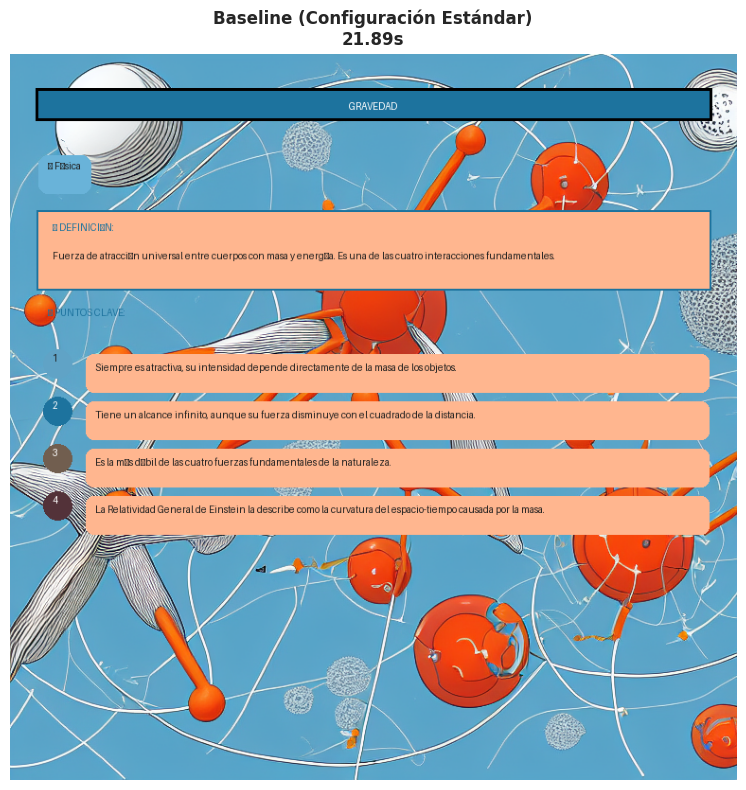


🧪 EXPERIMENTO: Alta Calidad (Más Pasos)


  0%|          | 0/50 [00:00<?, ?it/s]

  🎨 Colores: Fondo=(255, 255, 255), Acento=(245, 196, 41)
✓ Completado en 27.47s


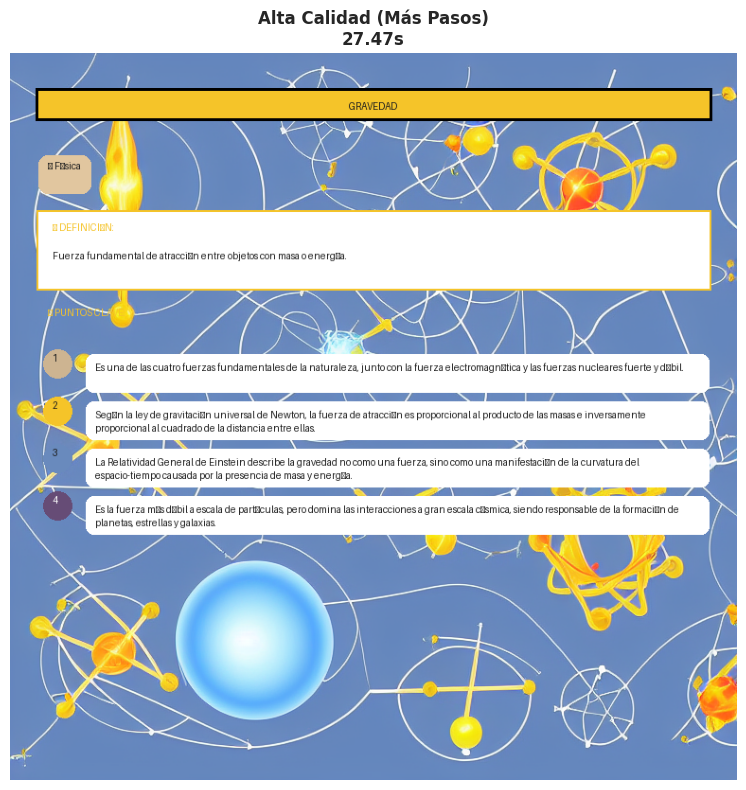


🧪 EXPERIMENTO: Creativo (Mayor Guidance)


  0%|          | 0/35 [00:00<?, ?it/s]

  🎨 Colores: Fondo=(87, 232, 255), Acento=(114, 106, 95)
✓ Completado en 21.97s


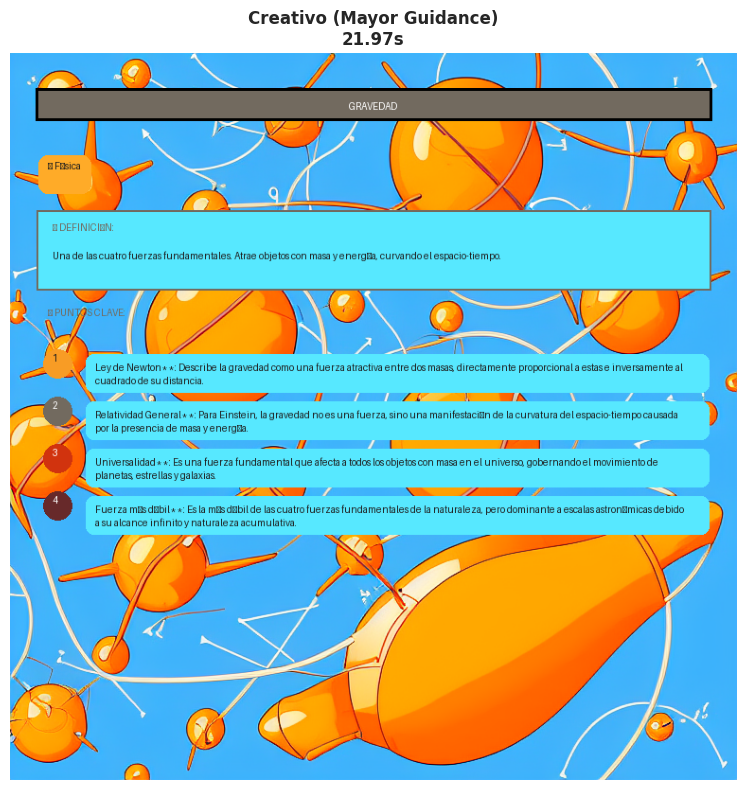


✓ Experimentación completada
  Total de experimentos ejecutados: 3


In [ ]:
# ==========================================
# PASO 18: Ejecutar los 3 Experimentos
# ==========================================

# Caso de prueba
tema_prueba = "física"
concepto_prueba = "gravedad"
estilo_prueba = "Educativo Clásico"

print("🚀 Iniciando experimentación...")
print(f"📚 Caso de prueba: {concepto_prueba} en {tema_prueba}")
print(f"🎨 Estilo: {estilo_prueba}\n")

# Ejecutar cada experimento
for exp_id, config in EXPERIMENTOS.items():
    resultado = ejecutar_experimento(
        tema_prueba,
        concepto_prueba,
        estilo_prueba,
        config,
        config['nombre']
    )
    resultados_experimentos.append(resultado)

    # Mostrar imagen
    plt.figure(figsize=(8, 8))
    plt.imshow(resultado['imagen'])
    plt.title(f"{config['nombre']}\n{resultado['tiempo_segundos']}s",
              fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

print(f"\n✓ Experimentación completada")
print(f"  Total de experimentos ejecutados: {len(resultados_experimentos)}")

In [ ]:
# ==========================================
# PASO 19: Métricas de Evaluación para Texto
# ==========================================

from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import textstat

def evaluar_texto_educativo(texto_generado, texto_referencia=None):
    """
    Evalúa la calidad del texto generado usando múltiples métricas
    """
    metricas = {}

    # 1. Métricas de legibilidad
    metricas['flesch_reading_ease'] = textstat.flesch_reading_ease(texto_generado)
    metricas['longitud_caracteres'] = len(texto_generado)
    metricas['longitud_palabras'] = len(texto_generado.split())

    # 2. Si hay texto de referencia, calcular ROUGE y BLEU
    if texto_referencia:
        # ROUGE
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        scores_rouge = scorer.score(texto_referencia, texto_generado)

        metricas['rouge1_f1'] = scores_rouge['rouge1'].fmeasure
        metricas['rouge2_f1'] = scores_rouge['rouge2'].fmeasure
        metricas['rougeL_f1'] = scores_rouge['rougeL'].fmeasure

        # BLEU
        smoothing = SmoothingFunction().method1
        ref_tokens = [texto_referencia.split()]
        gen_tokens = texto_generado.split()
        metricas['bleu_score'] = sentence_bleu(ref_tokens, gen_tokens, smoothing_function=smoothing)

    # 3. Métricas educativas personalizadas
    palabras = texto_generado.split()
    palabras_unicas = set(palabras)
    metricas['diversidad_lexica'] = len(palabras_unicas) / len(palabras) if palabras else 0

    # Detectar términos técnicos (palabras largas)
    terminos_tecnicos = [p for p in palabras if len(p) > 8]
    metricas['densidad_terminos_tecnicos'] = len(terminos_tecnicos) / len(palabras) if palabras else 0

    return metricas

# Evaluar textos de los experimentos
print("📊 Evaluando textos generados...\n")

for resultado in resultados_experimentos:
    if resultado['definicion']:
        texto_completo = resultado['definicion'] + " " + " ".join(resultado['puntos'])
        metricas = evaluar_texto_educativo(texto_completo)

        resultado['metricas_texto'] = metricas

        print(f"🧪 {resultado['experimento']}")
        print(f"  Legibilidad (Flesch): {metricas['flesch_reading_ease']:.1f}")
        print(f"  Diversidad léxica: {metricas['diversidad_lexica']:.2%}")
        print(f"  Términos técnicos: {metricas['densidad_terminos_tecnicos']:.2%}")
        print()

print("✓ Evaluación de texto completada")

📊 Evaluando textos generados...

🧪 Baseline (Configuración Estándar)
  Legibilidad (Flesch): 32.5
  Diversidad léxica: 73.61%
  Términos técnicos: 20.83%

🧪 Alta Calidad (Más Pasos)
  Legibilidad (Flesch): 26.9
  Diversidad léxica: 62.39%
  Términos técnicos: 21.37%

🧪 Creativo (Mayor Guidance)
  Legibilidad (Flesch): 22.2
  Diversidad léxica: 70.09%
  Términos técnicos: 24.79%

✓ Evaluación de texto completada


In [ ]:
# ==========================================
# PASO 20: Métricas de Evaluación para Imágenes
# ==========================================

import numpy as np
from PIL import ImageStat

def evaluar_calidad_imagen(imagen_pil):
    """
    Evalúa la calidad visual de la imagen generada
    """
    metricas = {}

    # Convertir a array numpy
    img_array = np.array(imagen_pil)

    # 1. Diversidad de colores (número de colores únicos)
    if len(img_array.shape) == 3:
        # Reshape para contar colores únicos
        pixels = img_array.reshape(-1, img_array.shape[2])
        colores_unicos = len(np.unique(pixels, axis=0))
        metricas['colores_unicos'] = colores_unicos
        metricas['diversidad_color'] = min(colores_unicos / 10000, 1.0)  # Normalizado

    # 2. Contraste (desviación estándar de intensidades)
    img_gray = imagen_pil.convert('L')
    stat = ImageStat.Stat(img_gray)
    metricas['contraste_std'] = stat.stddev[0]
    metricas['brillo_promedio'] = stat.mean[0]

    # 3. Balance de brillo (qué tan balanceado está el histograma)
    histogram = img_gray.histogram()
    hist_array = np.array(histogram)
    hist_normalizado = hist_array / hist_array.sum()
    metricas['entropia_brillo'] = -np.sum(hist_normalizado * np.log2(hist_normalizado + 1e-10))

    # 4. Complejidad visual (variación de gradientes)
    img_array_gray = np.array(img_gray)
    gradiente_x = np.abs(np.diff(img_array_gray, axis=1)).mean()
    gradiente_y = np.abs(np.diff(img_array_gray, axis=0)).mean()
    metricas['complejidad_visual'] = (gradiente_x + gradiente_y) / 2

    # 5. Puntuación de calidad general (0-100)
    # Combinación ponderada de métricas
    calidad = (
        metricas['diversidad_color'] * 30 +
        min(metricas['contraste_std'] / 50, 1.0) * 25 +
        (metricas['entropia_brillo'] / 8) * 25 +
        min(metricas['complejidad_visual'] / 20, 1.0) * 20
    )
    metricas['calidad_general'] = round(calidad, 2)

    return metricas

# Evaluar imágenes de los experimentos
print("🎨 Evaluando calidad de imágenes...\n")

for resultado in resultados_experimentos:
    metricas = evaluar_calidad_imagen(resultado['imagen'])
    resultado['metricas_imagen'] = metricas

    print(f"🧪 {resultado['experimento']}")
    print(f"  Calidad general: {metricas['calidad_general']:.1f}/100")
    print(f"  Diversidad de color: {metricas['diversidad_color']:.2%}")
    print(f"  Contraste: {metricas['contraste_std']:.1f}")
    print(f"  Complejidad visual: {metricas['complejidad_visual']:.1f}")
    print()

print("✓ Evaluación de imágenes completada")

🎨 Evaluando calidad de imágenes...

🧪 Baseline (Configuración Estándar)
  Calidad general: 85.1/100
  Diversidad de color: 100.00%
  Contraste: 40.5
  Complejidad visual: 55.9

🧪 Alta Calidad (Más Pasos)
  Calidad general: 88.8/100
  Diversidad de color: 100.00%
  Contraste: 57.0
  Complejidad visual: 48.4

🧪 Creativo (Mayor Guidance)
  Calidad general: 82.1/100
  Diversidad de color: 100.00%
  Contraste: 33.9
  Complejidad visual: 54.4

✓ Evaluación de imágenes completada


/tmp/ipython-input-3153373244.py:68: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3153373244.py:68: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3153373244.py:68: UserWarning: Glyph 127752 (\N{RAINBOW}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3153373244.py:68: UserWarning: Glyph 128248 (\N{CAMERA WITH FLASH}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3153373244.py:68: UserWarning: Glyph 128214 (\N{OPEN BOOK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3153373244.py:68: UserWarning: Glyph 128218 (\N{BOOKS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3153373244.py:68: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3153373244.py:69: UserWarning: Glyph 9

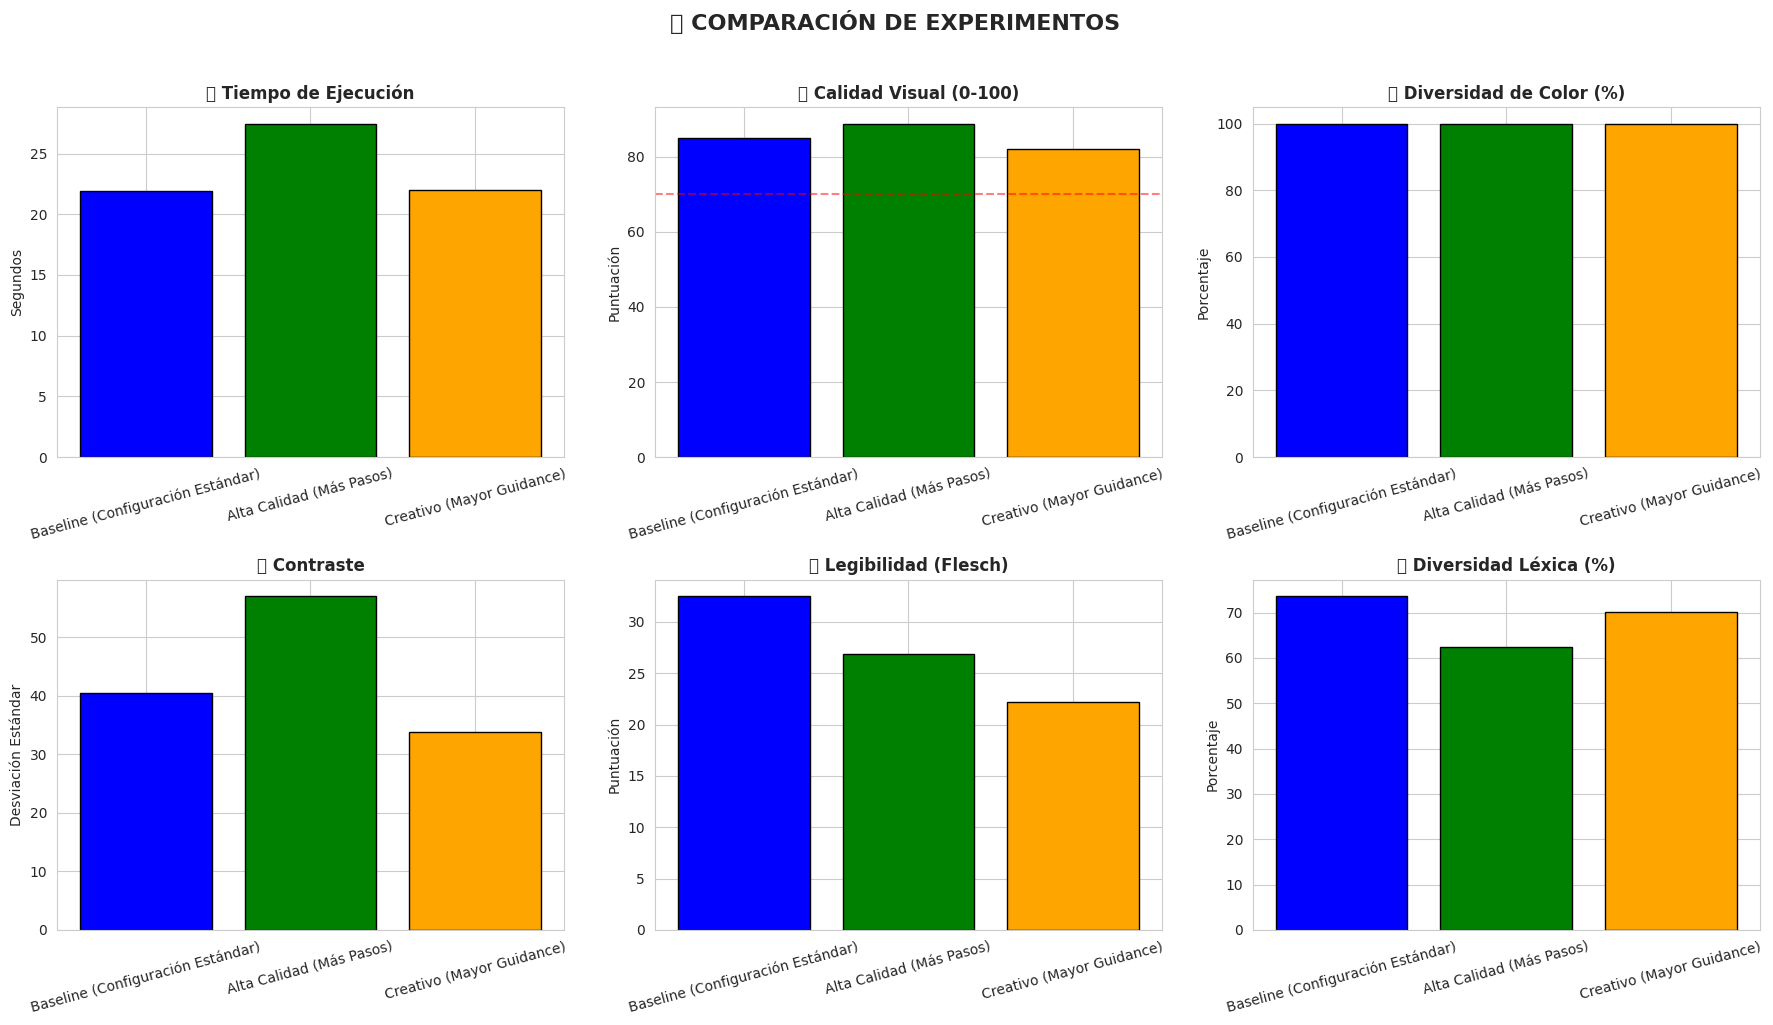


📋 TABLA RESUMEN DE EXPERIMENTOS
                      Experimento  Steps  Guidance  Tiempo (s)  Calidad Visual  Diversidad Color  Contraste  Legibilidad  Diversidad Léxica
Baseline (Configuración Estándar)     35       7.5       21.89           85.09             100.0  40.509635    32.505000          73.611111
         Alta Calidad (Más Pasos)     50       7.5       27.47           88.82             100.0  57.019736    26.899385          62.393162
        Creativo (Mayor Guidance)     35      12.0       21.97           82.09             100.0  33.876307    22.180962          70.085470

🏆 MEJOR EXPERIMENTO: Alta Calidad (Más Pasos)
   Calidad Visual: 88.8/100
   Tiempo: 27.5s

✓ Comparación de experimentos completada
  Gráfico guardado: comparacion_experimentos.png


In [ ]:
# ==========================================
# PASO 21: Visualización Comparativa de Experimentos
# ==========================================

# Crear DataFrame con resultados
df_resultados = pd.DataFrame([
    {
        'Experimento': r['experimento'],
        'Steps': r['sd_steps'],
        'Guidance': r['sd_guidance'],
        'Tiempo (s)': r['tiempo_segundos'],
        'Calidad Visual': r['metricas_imagen']['calidad_general'],
        'Diversidad Color': r['metricas_imagen']['diversidad_color'] * 100,
        'Contraste': r['metricas_imagen']['contraste_std'],
        'Legibilidad': r['metricas_texto']['flesch_reading_ease'],
        'Diversidad Léxica': r['metricas_texto']['diversidad_lexica'] * 100
    }
    for r in resultados_experimentos
])

# Crear visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('📊 COMPARACIÓN DE EXPERIMENTOS', fontsize=16, fontweight='bold', y=1.02)

# Gráfico 1: Tiempo de ejecución
axes[0, 0].bar(df_resultados['Experimento'], df_resultados['Tiempo (s)'],
               color=['blue', 'green', 'orange'], edgecolor='black')
axes[0, 0].set_title('⏱️ Tiempo de Ejecución', fontweight='bold')
axes[0, 0].set_ylabel('Segundos')
axes[0, 0].tick_params(axis='x', rotation=15)

# Gráfico 2: Calidad visual
axes[0, 1].bar(df_resultados['Experimento'], df_resultados['Calidad Visual'],
               color=['blue', 'green', 'orange'], edgecolor='black')
axes[0, 1].set_title('🎨 Calidad Visual (0-100)', fontweight='bold')
axes[0, 1].set_ylabel('Puntuación')
axes[0, 1].tick_params(axis='x', rotation=15)
axes[0, 1].axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Umbral')

# Gráfico 3: Diversidad de color
axes[0, 2].bar(df_resultados['Experimento'], df_resultados['Diversidad Color'],
               color=['blue', 'green', 'orange'], edgecolor='black')
axes[0, 2].set_title('🌈 Diversidad de Color (%)', fontweight='bold')
axes[0, 2].set_ylabel('Porcentaje')
axes[0, 2].tick_params(axis='x', rotation=15)

# Gráfico 4: Contraste
axes[1, 0].bar(df_resultados['Experimento'], df_resultados['Contraste'],
               color=['blue', 'green', 'orange'], edgecolor='black')
axes[1, 0].set_title('📸 Contraste', fontweight='bold')
axes[1, 0].set_ylabel('Desviación Estándar')
axes[1, 0].tick_params(axis='x', rotation=15)

# Gráfico 5: Legibilidad
axes[1, 1].bar(df_resultados['Experimento'], df_resultados['Legibilidad'],
               color=['blue', 'green', 'orange'], edgecolor='black')
axes[1, 1].set_title('📖 Legibilidad (Flesch)', fontweight='bold')
axes[1, 1].set_ylabel('Puntuación')
axes[1, 1].tick_params(axis='x', rotation=15)

# Gráfico 6: Diversidad léxica
axes[1, 2].bar(df_resultados['Experimento'], df_resultados['Diversidad Léxica'],
               color=['blue', 'green', 'orange'], edgecolor='black')
axes[1, 2].set_title('📚 Diversidad Léxica (%)', fontweight='bold')
axes[1, 2].set_ylabel('Porcentaje')
axes[1, 2].tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.savefig('comparacion_experimentos.png', dpi=150, bbox_inches='tight')
plt.show()

# Mostrar tabla resumen
print("\n📋 TABLA RESUMEN DE EXPERIMENTOS")
print("="*80)
print(df_resultados.to_string(index=False))
print("="*80)

# Identificar mejor experimento
mejor_exp = df_resultados.loc[df_resultados['Calidad Visual'].idxmax()]
print(f"\n🏆 MEJOR EXPERIMENTO: {mejor_exp['Experimento']}")
print(f"   Calidad Visual: {mejor_exp['Calidad Visual']:.1f}/100")
print(f"   Tiempo: {mejor_exp['Tiempo (s)']:.1f}s")

print("\n✓ Comparación de experimentos completada")
print("  Gráfico guardado: comparacion_experimentos.png")


In [ ]:
# ==========================================
# PASO 22: Detector de Sesgos en Contenido Generado
# ==========================================

def detectar_sesgos(texto, tema):
    """
    Detecta posibles sesgos en el contenido generado
    """
    sesgos_detectados = []

    # 1. Sesgo de género
    palabras_genero_masculino = ['él', 'hombre', 'masculino', 'padre', 'hijo']
    palabras_genero_femenino = ['ella', 'mujer', 'femenino', 'madre', 'hija']

    texto_lower = texto.lower()
    count_masc = sum(1 for p in palabras_genero_masculino if p in texto_lower)
    count_fem = sum(1 for p in palabras_genero_femenino if p in texto_lower)

    if count_masc > count_fem * 2:
        sesgos_detectados.append({
            'tipo': 'Sesgo de Género',
            'descripcion': 'Predominio de referencias masculinas',
            'severidad': 'Media',
            'ratio': f'{count_masc}:{count_fem}'
        })

    # 2. Sesgo de complejidad
    palabras = texto.split()
    palabras_complejas = [p for p in palabras if len(p) > 12]
    densidad_complejidad = len(palabras_complejas) / len(palabras) if palabras else 0

    if densidad_complejidad > 0.15:
        sesgos_detectados.append({
            'tipo': 'Sesgo de Complejidad',
            'descripcion': 'Lenguaje excesivamente técnico',
            'severidad': 'Alta',
            'densidad': f'{densidad_complejidad:.1%}'
        })

    # 3. Sesgo cultural (ejemplos occidentales)
    referencias_occidentales = ['europa', 'américa', 'occidente', 'eeuu', 'estados unidos']
    referencias_otras = ['asia', 'áfrica', 'latinoamérica', 'oriente']

    count_occ = sum(1 for r in referencias_occidentales if r in texto_lower)
    count_otras = sum(1 for r in referencias_otras if r in texto_lower)

    if count_occ > 0 and count_otras == 0:
        sesgos_detectados.append({
            'tipo': 'Sesgo Cultural',
            'descripcion': 'Solo referencias a contextos occidentales',
            'severidad': 'Media',
            'referencias': count_occ
        })

    # 4. Sesgo de representación (falta de diversidad en ejemplos)
    if len(palabras) < 50:
        sesgos_detectados.append({
            'tipo': 'Sesgo de Representación',
            'descripcion': 'Contenido muy breve, poca diversidad de ideas',
            'severidad': 'Baja',
            'longitud': len(palabras)
        })

    return sesgos_detectados

# Analizar sesgos en los experimentos
print("⚖️ ANÁLISIS DE SESGOS\n")
print("="*70)

for resultado in resultados_experimentos:
    if resultado['definicion']:
        texto_completo = resultado['definicion'] + " " + " ".join(resultado['puntos'])
        sesgos = detectar_sesgos(texto_completo, resultado['tema'])

        resultado['sesgos'] = sesgos

        print(f"\n🧪 {resultado['experimento']}")
        if sesgos:
            for sesgo in sesgos:
                print(f"  ⚠️ {sesgo['tipo']} (Severidad: {sesgo['severidad']})")
                print(f"     {sesgo['descripcion']}")
        else:
            print("  ✓ No se detectaron sesgos significativos")

print("\n" + "="*70)
print("✓ Análisis de sesgos completado")

⚖️ ANÁLISIS DE SESGOS


🧪 Baseline (Configuración Estándar)
  ✓ No se detectaron sesgos significativos

🧪 Alta Calidad (Más Pasos)
  ✓ No se detectaron sesgos significativos

🧪 Creativo (Mayor Guidance)
  ✓ No se detectaron sesgos significativos

✓ Análisis de sesgos completado


In [ ]:
# ==========================================
# PASO 23: Estrategias de Mitigación de Sesgos
# ==========================================

# Definir estrategias de mitigación
ESTRATEGIAS_MITIGACION = {
    'Sesgo de Género': [
        '✓ Usar lenguaje inclusivo y neutro',
        '✓ Incluir ejemplos con diversidad de género',
        '✓ Revisar y balancear referencias pronominales',
        '✓ Validar con expertos en equidad de género'
    ],
    'Sesgo de Complejidad': [
        '✓ Adaptar vocabulario al nivel educativo',
        '✓ Incluir definiciones de términos técnicos',
        '✓ Usar analogías y ejemplos simples',
        '✓ Aplicar pruebas de legibilidad'
    ],
    'Sesgo Cultural': [
        '✓ Incluir ejemplos de diversas culturas',
        '✓ Evitar asumir contexto occidental',
        '✓ Consultar con educadores de diferentes regiones',
        '✓ Usar referencias globales y locales'
    ],
    'Sesgo de Representación': [
        '✓ Ampliar el contenido generado',
        '✓ Incluir múltiples perspectivas',
        '✓ Diversificar fuentes de información',
        '✓ Validar cobertura de temas'
    ]
}

# Generar reporte de mitigación
print("🛡️ ESTRATEGIAS DE MITIGACIÓN DE SESGOS\n")
print("="*70)

sesgos_encontrados = set()
for resultado in resultados_experimentos:
    if 'sesgos' in resultado:
        for sesgo in resultado['sesgos']:
            sesgos_encontrados.add(sesgo['tipo'])

if sesgos_encontrados:
    print("Se detectaron los siguientes tipos de sesgos:\n")
    for tipo_sesgo in sesgos_encontrados:
        print(f"📌 {tipo_sesgo}")
        if tipo_sesgo in ESTRATEGIAS_MITIGACION:
            for estrategia in ESTRATEGIAS_MITIGACION[tipo_sesgo]:
                print(f"   {estrategia}")
        print()
else:
    print("✓ No se detectaron sesgos significativos en los experimentos")

print("="*70)

# Estrategias generales adicionales
print("\n🔧 ESTRATEGIAS GENERALES DE MITIGACIÓN:\n")
print("1. 👥 Validación Humana Obligatoria")
print("   - Todo contenido debe ser revisado por educadores")
print("   - Implementar sistema de aprobación antes de publicar")
print()
print("2. 🤖 Disclaimer de Contenido IA")
print("   - Indicar claramente que el contenido es generado por IA")
print("   - Advertir sobre posibles imprecisiones")
print()
print("3. 🚫 Filtros de Contenido Inapropiado")
print("   - Implementar safety checker en Stable Diffusion")
print("   - Filtrar lenguaje ofensivo o discriminatorio")
print()
print("4. 🌍 Diversificación de Prompts")
print("   - Incluir perspectivas culturales diversas")
print("   - Rotar ejemplos de diferentes regiones")

print("\n✓ Estrategias de mitigación documentadas")


🛡️ ESTRATEGIAS DE MITIGACIÓN DE SESGOS

✓ No se detectaron sesgos significativos en los experimentos

🔧 ESTRATEGIAS GENERALES DE MITIGACIÓN:

1. 👥 Validación Humana Obligatoria
   - Todo contenido debe ser revisado por educadores
   - Implementar sistema de aprobación antes de publicar

2. 🤖 Disclaimer de Contenido IA
   - Indicar claramente que el contenido es generado por IA
   - Advertir sobre posibles imprecisiones

3. 🚫 Filtros de Contenido Inapropiado
   - Implementar safety checker en Stable Diffusion
   - Filtrar lenguaje ofensivo o discriminatorio

4. 🌍 Diversificación de Prompts
   - Incluir perspectivas culturales diversas
   - Rotar ejemplos de diferentes regiones

✓ Estrategias de mitigación documentadas


In [ ]:
# ==========================================
# PASO 24: Análisis de Riesgos e Impacto Social
# ==========================================

print("⚠️ ANÁLISIS DE RIESGOS E IMPACTO SOCIAL\n")
print("="*70)

# Riesgos identificados
riesgos = {
    'Desinformación Educativa': {
        'descripcion': 'El contenido generado puede contener errores factuales',
        'probabilidad': 'Media',
        'impacto': 'Alto',
        'mitigacion': 'Validación por expertos educativos antes de uso'
    },
    'Perpetuación de Sesgos': {
        'descripcion': 'Los modelos pueden amplificar sesgos existentes',
        'probabilidad': 'Media-Alta',
        'impacto': 'Medio',
        'mitigacion': 'Sistema de detección y análisis de sesgos implementado'
    },
    'Privacidad de Datos': {
        'descripcion': 'Uso de APIs externas puede comprometer privacidad',
        'probabilidad': 'Baja',
        'impacto': 'Medio',
        'mitigacion': 'No almacenar datos sensibles, usar APIs confiables'
    },
    'Calidad Inconsistente': {
        'descripcion': 'Variabilidad en calidad de outputs generados',
        'probabilidad': 'Alta',
        'impacto': 'Medio',
        'mitigacion': 'Métricas de evaluación y sistema de rating'
    },
    'Dependencia Tecnológica': {
        'descripcion': 'Dependencia de APIs y servicios externos',
        'probabilidad': 'Alta',
        'impacto': 'Medio',
        'mitigacion': 'Implementar fallbacks y alternativas locales'
    }
}

print("🚨 RIESGOS IDENTIFICADOS:\n")
for riesgo, detalles in riesgos.items():
    print(f"📍 {riesgo}")
    print(f"   Descripción: {detalles['descripcion']}")
    print(f"   Probabilidad: {detalles['probabilidad']} | Impacto: {detalles['impacto']}")
    print(f"   Mitigación: {detalles['mitigacion']}")
    print()

# Impacto social
print("="*70)
print("\n🌍 IMPACTO SOCIAL ESPERADO:\n")

impactos_positivos = [
    "✅ Democratización del acceso a materiales educativos de calidad",
    "✅ Reducción de carga de trabajo para educadores",
    "✅ Personalización del aprendizaje según nivel",
    "✅ Generación rápida de contenido visual atractivo",
    "✅ Escalabilidad de recursos educativos"
]

impactos_negativos = [
    "⚠️ Posible reducción de creatividad docente",
    "⚠️ Dependencia excesiva de tecnología",
    "⚠️ Brecha digital (requiere acceso a tecnología)",
    "⚠️ Riesgo de desempleo en creación de contenido",
    "⚠️ Posible desinformación si no se valida"
]

print("IMPACTOS POSITIVOS:")
for impacto in impactos_positivos:
    print(f"  {impacto}")

print("\nIMPACTOS NEGATIVOS POTENCIALES:")
for impacto in impactos_negativos:
    print(f"  {impacto}")

# Recomendaciones de uso responsable
print("\n" + "="*70)
print("\n📋 RECOMENDACIONES DE USO RESPONSABLE:\n")

recomendaciones = [
    "1. Usar como herramienta complementaria, no sustitutiva",
    "2. Validar todo contenido con expertos antes de uso educativo",
    "3. Indicar claramente que el contenido es generado por IA",
    "4. Monitorear y actualizar el sistema regularmente",
    "5. Capacitar a educadores en uso crítico de IA",
    "6. Implementar mecanismos de feedback de usuarios",
    "7. Respetar derechos de autor y propiedad intelectual",
    "8. Garantizar accesibilidad para todos los estudiantes"
]

for rec in recomendaciones:
    print(f"  {rec}")

print("\n✓ Análisis de riesgos e impacto completado")
print("="*70)

⚠️ ANÁLISIS DE RIESGOS E IMPACTO SOCIAL

🚨 RIESGOS IDENTIFICADOS:

📍 Desinformación Educativa
   Descripción: El contenido generado puede contener errores factuales
   Probabilidad: Media | Impacto: Alto
   Mitigación: Validación por expertos educativos antes de uso

📍 Perpetuación de Sesgos
   Descripción: Los modelos pueden amplificar sesgos existentes
   Probabilidad: Media-Alta | Impacto: Medio
   Mitigación: Sistema de detección y análisis de sesgos implementado

📍 Privacidad de Datos
   Descripción: Uso de APIs externas puede comprometer privacidad
   Probabilidad: Baja | Impacto: Medio
   Mitigación: No almacenar datos sensibles, usar APIs confiables

📍 Calidad Inconsistente
   Descripción: Variabilidad en calidad de outputs generados
   Probabilidad: Alta | Impacto: Medio
   Mitigación: Métricas de evaluación y sistema de rating

📍 Dependencia Tecnológica
   Descripción: Dependencia de APIs y servicios externos
   Probabilidad: Alta | Impacto: Medio
   Mitigación: Implementar f

In [ ]:
# ==========================================
# PASO 25: Chatbot Response
# ==========================================
def chatbot_response(user_input, chat_history, estilo_seleccionado="Educativo Clásico"):
    """Función principal con colores adaptativos"""

    try:
        # 1. Extraer tema y concepto
        tema, concepto = extract_topic_and_concept(user_input)
        print(f"📚 Tema: {tema} | Concepto: {concepto} | Estilo: {estilo_seleccionado}")

        # 2. Generar con Gemini
        definicion, puntos, gemini_full_text = generate_with_gemini(tema, concepto)

        # 3. Crear respuesta para el chat
        if definicion and puntos:
            respuesta_chat = f"""🤖 **Respuesta de Gemini**

**💡 Definición:**
{definicion}

**✨ Puntos Clave:**
{chr(10).join(f'{i}. {p}' for i, p in enumerate(puntos, 1))}

---
🎨 **Estilo:** {estilo_seleccionado}
_Generando infografía temática con colores adaptativos..._"""
            print("✓ Contenido de Gemini obtenido")
        else:
            definicion = f"{concepto.title()} es un concepto en {tema}"
            puntos = [
                f"Fundamental en {tema}",
                "Requiere estudio y práctica",
                "Tiene aplicaciones prácticas",
                "Base para temas avanzados"
            ]
            respuesta_chat = f"""⚠️ **Contenido Genérico**

**Definición:** {definicion}

**Puntos:** {', '.join(puntos)}"""
            print("⚠️ Usando fallback")

        # 4. Generar fondo visual ESPECÍFICO del tema
        print(f"🎨 Generando imagen temática de {tema}...")
        background, paleta_colores = generate_visual_background(tema, concepto, estilo_seleccionado)

        # 5. Añadir texto con colores EXTRAÍDOS de la imagen
        print("✍️ Aplicando overlay con colores adaptativos...")
        infografia = add_text_overlay(background, tema, concepto, definicion, puntos, paleta_colores)

        # 6. Actualizar historial
        chat_history.append((user_input, respuesta_chat))

        return chat_history, infografia

    except Exception as e:
        import traceback
        error_msg = f"❌ Error: {str(e)}\n{traceback.format_exc()}"
        print(error_msg)
        chat_history.append((user_input, f"❌ Error: {str(e)}"))
        return chat_history, None


In [ ]:

# ==========================================
# PASO 26: Interfaz de Gradio
# ==========================================
def create_gradio_interface():
    """Interfaz con selector de estilo visual"""

    with gr.Blocks(theme=gr.themes.Soft(primary_hue="blue")) as demo:
        gr.Markdown("""
        # 📚 Chatbot de Infografías Educativas
        ### Powered by Gemini API + Stable Diffusion

        Crea infografías personalizadas con diferentes estilos visuales
        """)

        with gr.Row():
            with gr.Column(scale=1):
                chatbot = gr.Chatbot(label="💬 Conversación", height=450)

                msg = gr.Textbox(
                    label="Tu pregunta",
                    placeholder="Ej: deseo una infografía sobre física de la gravedad",
                    lines=2
                )

                # ✅ NUEVO: Selector de estilo
                estilo_dropdown = gr.Dropdown(
                    choices=list(ESTILOS_VISUALES.keys()),
                    value="Educativo Clásico",
                    label="🎨 Estilo Visual",
                    info="Selecciona el estilo de tu infografía"
                )

                with gr.Row():
                    submit_btn = gr.Button("🚀 Generar", variant="primary", scale=2)
                    clear_btn = gr.Button("🗑️ Limpiar", scale=1)

            with gr.Column(scale=1):
                image_output = gr.Image(label="🎨 Infografía", height=500)

                # ✅ NUEVO: Descripción del estilo
                gr.Markdown("""
                **Estilos disponibles:**
                - 🎨 **Minimalista**: Líneas simples, blanco y negro
                - 🖼️ **Artístico**: Estilo Van Gogh, texturizado
                - 🎬 **3D Moderno**: Render 3D, iluminación cinematográfica
                - 📖 **Educativo Clásico**: Estilo libro de texto
                """)

        gr.Examples(
            examples=[
                "deseo una infografía sobre matemáticas de ecuaciones cuadráticas",
                "física sobre la gravedad",
                "biología sobre la fotosíntesis",
                "química sobre enlaces químicos"
            ],
            inputs=msg
        )

        # Event handlers con estilo
        submit_btn.click(
            chatbot_response,
            [msg, chatbot, estilo_dropdown],
            [chatbot, image_output]
        )
        msg.submit(
            chatbot_response,
            [msg, chatbot, estilo_dropdown],
            [chatbot, image_output]
        )
        clear_btn.click(
            lambda: ([], None, ""),
            outputs=[chatbot, image_output, msg]
        )

    return demo


In [ ]:
# ==========================================
# PASO 27: Lanzar Aplicación
# ==========================================
print("🚀 Iniciando aplicación...")
demo = create_gradio_interface()
demo.launch(share=True, debug=True, server_name="0.0.0.0", server_port=7860)


🚀 Iniciando aplicación...


NameError: name 'create_gradio_interface' is not defined